In [4]:
import pandas as pd
import json
def getdf(data_path):
    with open(data_path,'r')as f:
        df=json.load(f)
        df1=pd.DataFrame(df['images'])
        df2=pd.DataFrame(df['annotations'])
        df2['bbox']=df2.apply(lambda x:x['bbox']+[x['category_id']] if len(x['bbox']) else [],axis=1)
        df2=df2.groupby(['image_id'])[['bbox']].agg(list).reset_index()
        df2['bbox']=df2['bbox'].apply(lambda x:[i for i in x if len(i)>0])
        df = df1.merge(df2, left_on='id', right_on='image_id', how='inner')
    return df
train_df=getdf("./flaw_data/train/train.json")
val_df=getdf("./flaw_data/val/val.json")
test_df=getdf("./flaw_data/test/test.json")

In [5]:
train_df.to_dict(orient='records')[0]

{'id': 0,
 'file_name': 'cam_1flaw20211011_234416_581000count1.jpg',
 'template_name': 'cam_1flaw20211011_234416_581000count1_template.jpg',
 'image_id': 0,
 'bbox': [[0, 0, 437, 544, 3]]}

In [6]:
import cv2
def getimage(df,path,temp_path):
    df['x']=df['file_name'].apply(lambda x:cv2.imread(f'{path}{x}'))
    df['x_template']=df['template_name'].apply(lambda x:cv2.imread(f'{temp_path}{x}'))
    df['x_shape']=df['x'].apply(lambda x:x.shape)
    df['x_template_shape']=df['x_template'].apply(lambda x:x.shape)
getimage(train_df,'./flaw_data/train/sample/','./flaw_data/train/template/')
getimage(val_df,'./flaw_data/val/sample/','./flaw_data/val/template/')
getimage(test_df,'./flaw_data/test/sample/','./flaw_data/test/template/')

### 数据研究

In [7]:
val_df['x_shape'].value_counts()

x_shape
(400, 400, 3)      1762
(400, 1586, 3)        2
(3087, 1412, 3)       1
(434, 618, 3)         1
(400, 1002, 3)        1
(400, 1952, 3)        1
(400, 622, 3)         1
(3087, 2048, 3)       1
(400, 1701, 3)        1
(400, 503, 3)         1
(400, 1619, 3)        1
(400, 691, 3)         1
(400, 1202, 3)        1
(2098, 400, 3)        1
(996, 400, 3)         1
(400, 1302, 3)        1
(2575, 831, 3)        1
(400, 978, 3)         1
(607, 758, 3)         1
(618, 897, 3)         1
(400, 416, 3)         1
(474, 655, 3)         1
(412, 588, 3)         1
(628, 848, 3)         1
Name: count, dtype: int64

In [8]:
a=train_df[train_df['bbox'].apply(lambda x:len(x)>0 and x[0][-1]==1)].to_dict(orient='records')[0]
a

{'id': 35,
 'file_name': 'cam_1flaw20211012_021845_350000count0.jpg',
 'template_name': 'cam_1flaw20211012_021845_350000count0_template.jpg',
 'image_id': 35,
 'bbox': [[0, 153, 2208, 91, 1]],
 'x': array([[[121, 107, 119],
         [120, 106, 118],
         [132, 117, 131],
         ...,
         [ 89, 112, 134],
         [ 87, 104, 130],
         [ 86, 103, 129]],
 
        [[117, 105, 117],
         [118, 106, 118],
         [131, 118, 132],
         ...,
         [ 93, 114, 136],
         [ 89, 106, 132],
         [ 88, 105, 131]],
 
        [[129, 119, 132],
         [130, 120, 133],
         [140, 130, 146],
         ...,
         [ 92, 108, 131],
         [ 87, 103, 126],
         [ 86, 102, 125]],
 
        ...,
 
        [[ 86,  98, 122],
         [ 86,  98, 122],
         [ 87,  99, 123],
         ...,
         [ 43,  48,  73],
         [ 44,  48,  73],
         [ 44,  48,  73]],
 
        [[ 84,  98, 121],
         [ 85,  99, 122],
         [ 86, 100, 123],
         ...,
   

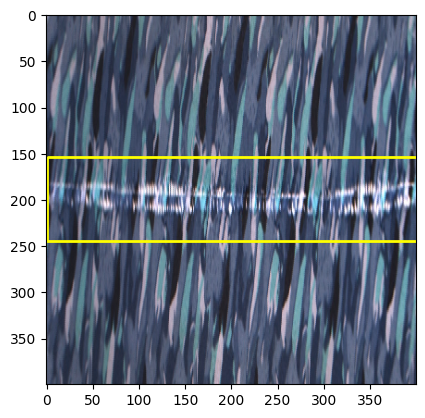

In [ ]:
import matplotlib.pyplot as plt
image=cv2.resize(a['x'], (400, 400))
plt.imshow(image)
xmin,ymin,xmax,ymax=0, 153, 2208, 91+153
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='yellow', fill=False, linewidth=2))
    
plt.show()

### yolo数据处理

In [9]:
def getlabel(df):
    # 归一化bbox
    df['bbox']=df.apply(lambda x:[[b[0]/x['x_shape'][1],b[1]/x['x_shape'][0],b[2]/x['x_shape'][1],b[3]/x['x_shape'][0],b[4]] for b in x['bbox']],axis=1)
    # 转化为yolo标准，(x_min,y_min,x_len,y_len,c)->(x_center,y_center,x_len,y_len,c)
    df['bbox']=df['bbox'].apply(lambda x:[[b[0]+b[2]/2,b[1]+b[3]/2,b[2],b[3],b[4]] for b in x])
getlabel(train_df)
getlabel(val_df)
getlabel(test_df)

In [10]:
def catTemp(df:pd.DataFrame):
    # 处理成400*400
    df['x']=df['x'].apply(lambda x:cv2.resize(x,(400,400)))
    df['x_template']=df['x_template'].apply(lambda x:cv2.resize(x,(400,400)))
    df['x_shape']=df['x'].apply(lambda x:x.shape)
    df['x_template_shape']=df['x_template'].apply(lambda x:x.shape)
catTemp(train_df)
catTemp(val_df)
catTemp(test_df)

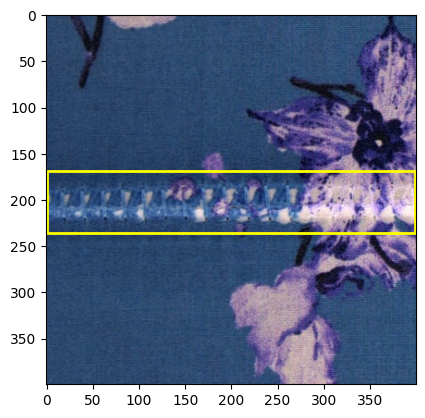

In [14]:
import matplotlib.pyplot as plt
ii=80
plt.imshow(train_df[train_df['bbox'].apply(lambda x:len(x)>0 and x[0][-1]==1)].iloc[ii]['x'])
y_len,x_len=train_df[train_df['bbox'].apply(lambda x:len(x)>0 and x[0][-1]==1)].iloc[ii]['x_shape'][0],train_df[train_df['bbox'].apply(lambda x:len(x)>0 and x[0][-1]==1)].iloc[ii]['x_shape'][1]
x_c,y_c,x_l,y_l,c=train_df[train_df['bbox'].apply(lambda x:len(x)>0 and x[0][-1]==1)].iloc[ii]['bbox'][0]
x_c,y_c,x_l,y_l=x_c*x_len,y_c*y_len,x_l*x_len,y_l*y_len
xmin,ymin,xmax,ymax=x_c-x_l/2,y_c-y_l/2,x_c+x_l/2,y_c+y_l/2
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='yellow', fill=False, linewidth=2))
plt.show()

In [277]:
train_df.describe()

,id,image_id
count,5360.000000,5360.000000
mean,2679.500000,2679.500000
std,1547.443052,1547.443052
min,0.000000,0.000000
25%,1339.750000,1339.750000
50%,2679.500000,2679.500000
75%,4019.250000,4019.250000
max,5359.000000,5359.000000


In [11]:
def is_bbox_in_bounds(bbox_list):
    for bbox_c in bbox_list:
        bbox=bbox_c[:-1]
        if min(bbox)<0 or max(bbox)>1:
            return False
        x_center, y_center, width, height = bbox
        x_min = x_center - width / 2
        x_max = x_center + width / 2
        y_min = y_center - height / 2
        y_max = y_center + height / 2
        if x_min < 0 or x_max > 1:
            return False
        if y_min < 0 or y_max > 1:
            return False
    return True

In [12]:
train_df_d=train_df[train_df['bbox'].apply(is_bbox_in_bounds)]
val_df_d=val_df[val_df['bbox'].apply(is_bbox_in_bounds)]

In [13]:
train_df_d.shape

(5354, 9)

In [15]:
train_df_d.to_pickle('./train.pkl')
val_df_d.to_pickle('./val.pkl')
test_df.to_pickle('./test.pkl')

## 数据增强

In [16]:
import pandas as pd
df_train=pd.read_pickle('./train.pkl')
df_val=pd.read_pickle('./val.pkl')
df_test=pd.read_pickle('./test.pkl')
df_train=df_train[df_train['bbox'].apply(is_bbox_in_bounds)]

### 加入template信息

In [5]:
# df_train['x']=df_train.apply(lambda x:x['x']-x['x_template'],axis=1)
# df_val['x']=df_val.apply(lambda x:x['x']-x['x_template'],axis=1)

In [17]:
import numpy as np
df_train['x']=df_train.apply(lambda x:np.concatenate([x['x'],x['x_template']],axis=-1),axis=1)
df_val['x']=df_val.apply(lambda x:np.concatenate([x['x'],x['x_template']],axis=-1),axis=1)
df_test['x']=df_test.apply(lambda x:np.concatenate([x['x'],x['x_template']],axis=-1),axis=1)

In [18]:
df_train['x'].loc[0].shape

(400, 400, 6)

### 样本均衡

In [27]:
df_train['category_id']=df_train['bbox'].apply(lambda x:0 if len(x)==0 else x[0][-1])

In [28]:
sz_dict=df_train['category_id'].value_counts().to_dict()

In [29]:
sz_dict

{0: 1742,
 2: 1019,
 1: 734,
 3: 630,
 4: 342,
 10: 141,
 8: 141,
 5: 123,
 6: 121,
 7: 116,
 9: 104,
 12: 60,
 11: 47,
 13: 34}

In [30]:
df_train['len']=df_train['bbox'].apply(lambda x:len(x))
df_train['len'].value_counts()

len
1    3554
0    1742
2      45
3       8
4       3
9       1
5       1
Name: count, dtype: int64

In [31]:
df_train[df_train['bbox'].apply(is_bbox_in_bounds)].shape,df_train.shape

((5354, 11), (5354, 11))

In [32]:
import numpy as np
import cv2

def hflip_image_and_bbox(image, bbox):
    image = cv2.flip(image, 1)
    bbox=[[1 - b[0],b[1],b[2],b[3],b[4]] for b in bbox]
    return image, bbox

def translate_image_and_bbox(image, bbox, tx, ty):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, tx*cols], [0, 1, ty*rows]])
    image = cv2.warpAffine(image, M, (cols, rows))
    bbox=[[b[0]+tx,b[1]+ty,b[2],b[3],b[4]] for b in bbox]
    return image, bbox
def gaussian_blur_image(image, bbox, kernel_size):
    blurred_image = cv2.GaussianBlur(image, (kernel_size,kernel_size), 0)
    return blurred_image, bbox
def scale_image_and_bbox(image, bbox, scale):
    original_size = image.shape[:2]
    image = cv2.resize(image, None, fx=scale, fy=scale)
    image = cv2.resize(image, (original_size[1], original_size[0]))
    return image, bbox
def rotate_image_and_bbox(image, bbox, angle):
    rows, cols = image.shape[:2]
    if angle == 90:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
        image = cv2.warpAffine(image, M, (cols, rows))
        bbox=[[1 - b[1], b[0],b[3], b[2],b[4]] for b in bbox]
    elif angle == 180:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 180, 1)
        image = cv2.warpAffine(image, M, (cols, rows))
        bbox=[[1 - b[0], 1 - b[1],b[2], b[3],b[4]] for b in bbox]
    elif angle == 270:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 270, 1)
        image = cv2.warpAffine(image, M, (cols, rows))
        bbox=[[b[1], 1 - b[0],b[3], b[2],b[4]] for b in bbox]
    return image, bbox

In [33]:
from random import random,randint,randrange
def aug(df,f):
    if f:
        df_train_a1=df.copy()
        df_train_a1[['x','bbox']]=df_train_a1.apply(lambda x:hflip_image_and_bbox(x['x'],x['bbox']),axis=1,result_type='expand')
    else:
        df_train_a1=pd.DataFrame()
    df_train_a2=df.copy()
    df_train_a2[['x','bbox']]=df_train_a2.apply(lambda x:translate_image_and_bbox(x['x'],x['bbox'],random()/2,random()/2),axis=1,result_type='expand')
    df_train_a3=df.copy()
    df_train_a3[['x','bbox']]=df_train_a3.apply(lambda x:scale_image_and_bbox(x['x'],x['bbox'],(random()+0.1)*2),axis=1,result_type='expand')
    df_train_a4=df.copy()
    df_train_a4[['x','bbox']]=df_train_a4.apply(lambda x:rotate_image_and_bbox(x['x'],x['bbox'],randint(0,2)*90),axis=1,result_type='expand')
    # df_train_a5=df.copy()
    # df_train_a5[['x','bbox']]=df_train_a5.apply(lambda x:gaussian_blur_image(x['x'],x['bbox'],randrange(3,10,2)),axis=1,result_type='expand')
    df_train_ex=pd.concat([df_train_a1,df_train_a2,df_train_a3,df_train_a4])
    return df_train_ex
df_train_ex1=aug(df_train,1)
df_train_ex2=aug(df_train.copy(),0)
df_train_ex3=aug(df_train.copy(),0)
df_train_ex=pd.concat([df_train_ex1,df_train_ex2,df_train_ex3])
df_train_ex=df_train_ex[df_train_ex['bbox'].apply(lambda x:len(x)!=0 and (is_bbox_in_bounds(x)))]
df_list=[]
for i in range(1,14):
    dff=df_train_ex[df_train_ex['category_id']==i].sample(2000-sz_dict[i],replace=True)
    df_list.append(dff)
df_train=pd.concat([df_train,pd.concat(df_list)])

In [34]:
print(df_train[df_train['bbox'].apply(is_bbox_in_bounds)].shape,df_train.shape)

(27742, 11) (27742, 11)


In [35]:
df_train['category_id'].value_counts()

category_id
3     2000
2     2000
11    2000
1     2000
5     2000
12    2000
10    2000
6     2000
7     2000
13    2000
4     2000
9     2000
8     2000
0     1742
Name: count, dtype: int64

1.0 167.0 400.0 241.0


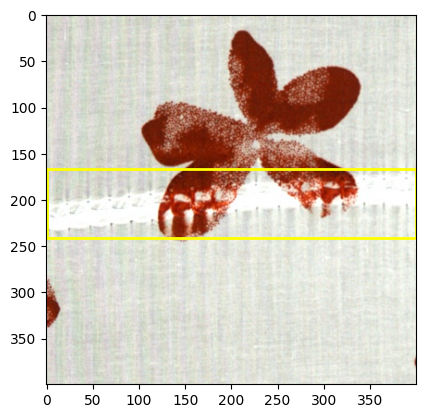

In [51]:
import matplotlib.pyplot as plt
ii=136
plt.imshow(df_train[df_train['category_id']==1].iloc[ii]['x'][:,:,:3])
y_len,x_len=400,400
x_c,y_c,x_l,y_l=df_train[df_train['category_id']==1].iloc[ii]['bbox'][0][:-1]
x_c,y_c,x_l,y_l=x_c*x_len,y_c*y_len,x_l*x_len,y_l*y_len
xmin,ymin,xmax,ymax=x_c-x_l/2,y_c-y_l/2,x_c+x_l/2,y_c+y_l/2
print(xmin,ymin,xmax,ymax)
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='yellow', fill=False, linewidth=2))
plt.show()

In [43]:
train_df_d=df_train.reset_index(drop=True)
val_df_d=df_val

In [21]:
test_df_d=df_test

In [20]:
test_df.iloc[1]['x'].shape

(400, 400, 6)

In [44]:
train_df_d[train_df_d['bbox'].apply(is_bbox_in_bounds)].shape,train_df_d.shape

((27742, 11), (27742, 11))

In [45]:
train_df_d[train_df_d['category_id']==1].to_dict(orient='records')[1600]

{'id': 1167,
 'file_name': '20220513_00801.jpg',
 'template_name': '20220513_00801_template.jpg',
 'image_id': 1167,
 'bbox': [[0.49750000000000005, 0.21750000000000003, 0.99, 0.105, 1]],
 'x': array([[[ 0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0],
         ...,
         [ 0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0,  0,  0],
         [17, 21, 22, 16, 16, 16],
         [16, 20, 21, 10, 10, 10],
         ...,
         [14, 16, 16, 24, 24, 24],
         [14, 16, 16, 17, 17, 17],
         [20, 22, 22, 11, 13, 13]],
 
        [[ 0,  0,  0,  0,  0,  0],
         [27, 31, 32, 13, 13, 13],
         [21, 25, 26, 12, 12, 12],
         ...,
         [15, 17, 17, 21, 21, 21],
         [16, 18, 18, 26, 26, 26],
         [19, 21, 21, 19, 21, 21]],
 
        ...,
 
        [[ 0,  0,  0,  0,  0,  0],
         [46, 65, 78, 31, 50, 57],
         [52, 71, 84, 30, 49, 56],
      

In [19]:
import os,cv2
def getYoloData(df,path_dst):
    os.makedirs(os.path.join(path_dst,'labels'), exist_ok=True)
    os.makedirs(os.path.join(path_dst,'images'), exist_ok=True)
    df_yolo=df[["bbox","x"]]
    for idx,row in df_yolo.iterrows():
        with open(os.path.join(path_dst+'labels',str(idx)+'.txt'),'w') as f:
            for b in row['bbox']:
                f.writelines(f"{b[4]-1} {b[0]} {b[1]} {b[2]} {b[3]}\n")
            f.close()
        cv2.imwrite(path_dst+'images/'+str(idx)+'.jpg',row['x'])
getYoloData(train_df_d,'./yolo_data_temp/train/')
getYoloData(val_df_d,'./yolo_data_temp/val/')

In [ ]:
import yaml
yolo_format=dict(train=os.path.join(os.getcwd(),"yolo_data_temp/train/images"),
                 val=os.path.join(os.getcwd(),"yolo_data_temp/val/images"),
                 nc=13,
                 names={0:'1',1:'2',2:'3',3:'4',4:'5',5:'6',6:'7',7:'8',8:'9',9:'10',10:'11',11:'12',12:'13'})
             
with open('./yolo_data_temp/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [22]:
import os,cv2
def getYoloData(df,path_dst):
    os.makedirs(os.path.join(path_dst,'labels'), exist_ok=True)
    os.makedirs(os.path.join(path_dst,'images'), exist_ok=True)
    df_yolo=df[["bbox","x"]]
    for idx,row in df_yolo.iterrows():
        with open(os.path.join(path_dst+'labels',str(idx)+'.txt'),'w') as f:
            for b in row['bbox']:
                f.writelines(f"{b[4]-1} {b[0]} {b[1]} {b[2]} {b[3]}\n")
            f.close()
        cv2.imwrite(path_dst+'images/'+str(idx)+'.jpg',row['x'][:,:,:3])
        np.save(path_dst+'images/'+str(idx),row['x'])
# getYoloData(train_df_d,'./yolo_data_6chan/train/')
# getYoloData(val_df_d,'./yolo_data_6chan/val/')
getYoloData(test_df_d,'./yolo_data_6chan/test/')

In [47]:
import yaml
yolo_format=dict(train=os.path.join(os.getcwd(),"yolo_data_6chan/train/images"),
                 val=os.path.join(os.getcwd(),"yolo_data_6chan/val/images"),
                 test=os.path.join(os.getcwd(),"yolo_data_6chan/test/images"),
                 nc=13,
                 names={0:'1',1:'2',2:'3',3:'4',4:'5',5:'6',6:'7',7:'8',8:'9',9:'10',10:'11',11:'12',12:'13'})
             
with open('./yolo_data_6chan/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)